# Alameda data

In [4]:
from PIL import Image
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np
import scipy as sp
import json
import os

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# 1. Visualizing matching points

In [5]:
# Directory structure:
# ./main.ipynb

# ./kp_gmaps.mat
# ./gmaps_alamedaIST.png
# ./yolo_classes.json

# ./images/imgfile.jpg
# ./yolo/yolofile.mat

In [6]:
file_path = 'kp_gmaps.mat'
data = sp.io.loadmat(file_path)['kp_gmaps']
match_video = data[:,:2]
match_maps = data[:,2:]

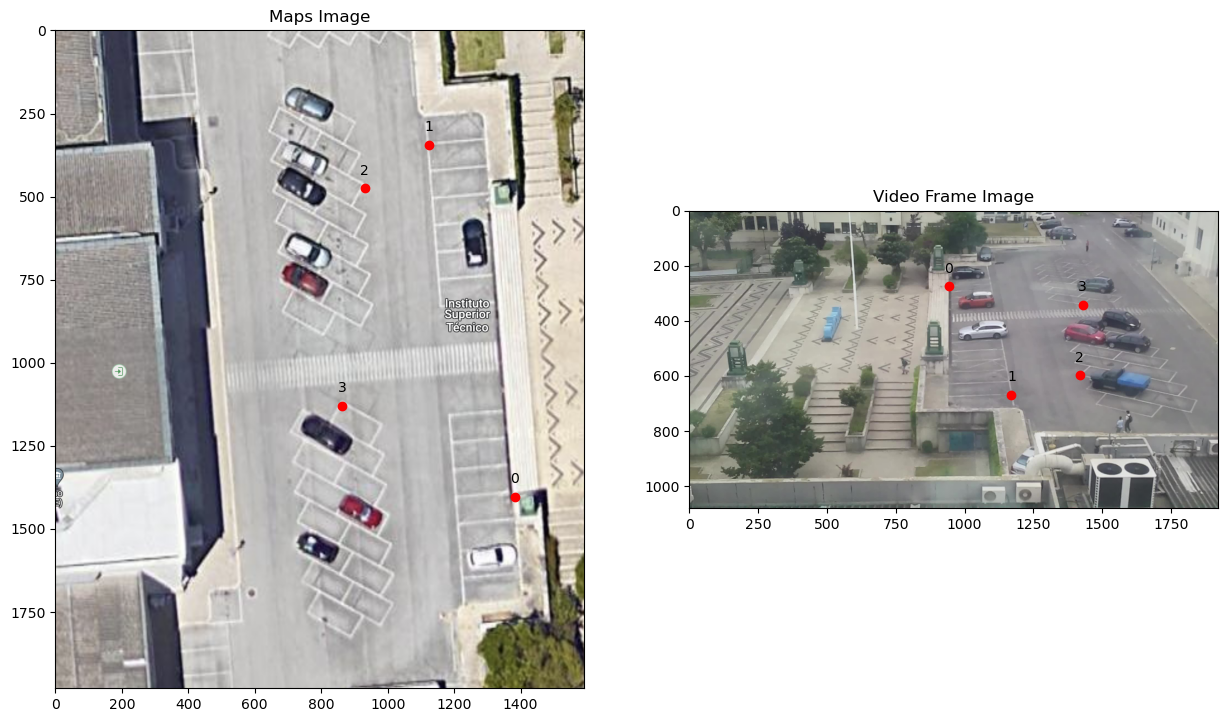

In [7]:

videoframe_1 = './images/img_0001.jpg'
maps = './gmaps_alamedaIST.png'

# Load the images
image_maps = Image.open(maps)
image_video = Image.open(videoframe_1)

# Convert the images to numpy arrays
image_maps_array = np.array(image_maps)
image_video_array = np.array(image_video)

# Create subplots
fig, axes = plt.subplots(1, 2, figsize=(15, 10))

# Plot the maps image
axes[0].imshow(image_maps_array)
axes[0].scatter(match_maps[:, 0], match_maps[:, 1], c='red', marker='o')
for i, (x, y) in enumerate(match_maps):
    axes[0].annotate(str(i), (x, y), textcoords="offset points", xytext=(0,10), ha='center')
axes[0].set_title('Maps Image')

# Plot the video frame image
axes[1].imshow(image_video_array)
axes[1].scatter(match_video[:, 0], match_video[:, 1], c='red', marker='o')
for i, (x, y) in enumerate(match_video):
    axes[1].annotate(str(i), (x, y), textcoords="offset points", xytext=(0,10), ha='center')
axes[1].set_title('Video Frame Image')

# Show the plot
plt.show()


# 2. Visualizing yolo data

In [8]:
yolo_classes_path =  'yolo_classes.json'

with open(yolo_classes_path, 'r') as file:
    yolo_classes = json.load(file)['class']

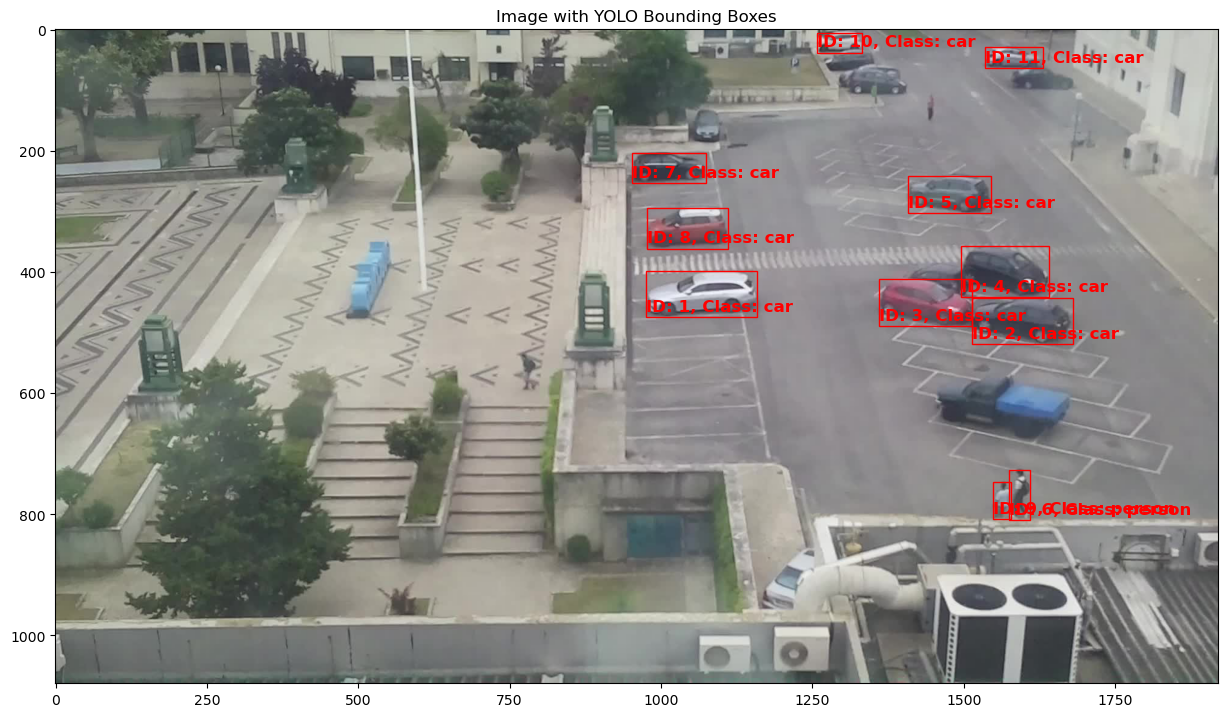

In [9]:
def plot_yolo_annotation(yolo_mat_file, image_file):
    # Load the YOLO mat file
    yolo_data = sp.io.loadmat(yolo_mat_file)
    
    # Extract bounding box coordinates, class ids, and object ids
    bounding_boxes = yolo_data['xyxy']
    class_ids = yolo_data['class'].flatten()
    object_ids = yolo_data['id'].flatten()
    
    # Load the image
    image = Image.open(image_file)
    image_array = np.array(image)
    
    # Plot the image with bounding boxes
    fig, ax = plt.subplots(figsize=(15, 10))
    ax.imshow(image_array)
    
    # Plot each bounding box
    for bbox, class_id, object_id in zip(bounding_boxes, class_ids, object_ids):
        x_min, y_min, x_max, y_max = bbox
        width, height = x_max - x_min, y_max - y_min
        rect = plt.Rectangle((x_min, y_min), width, height, edgecolor='red', facecolor='none')
        ax.add_patch(rect)
        ax.text(x_min, y_min - 10, f'ID: {object_id}, Class: {yolo_classes[str(class_id)]}', color='red', fontsize=12, weight='bold')
    
    ax.set_title('Image with YOLO Bounding Boxes')
    plt.show()

video_frame = '0001'
plot_yolo_annotation(f'yolo/yolo_{video_frame}.mat', f'./images/img_{video_frame}.jpg')

# 3. Computing homography

In [10]:
import cv2

# Define points in the video frame (source points)
src_points = match_video

# Define corresponding points in the image (destination points)
dst_points = match_maps

# Compute the homography matrix
H, status = cv2.findHomography(src_points, dst_points)

print("Homography matrix:")
print(H)

Homography matrix:
[[-1.80993224e+00  2.45954827e+00  3.38956185e+03]
 [ 4.18342244e-02 -3.83698593e+00  3.40878252e+03]
 [ 1.12300998e-04  2.18391544e-03  1.00000000e+00]]


# 4. Visualizing homography

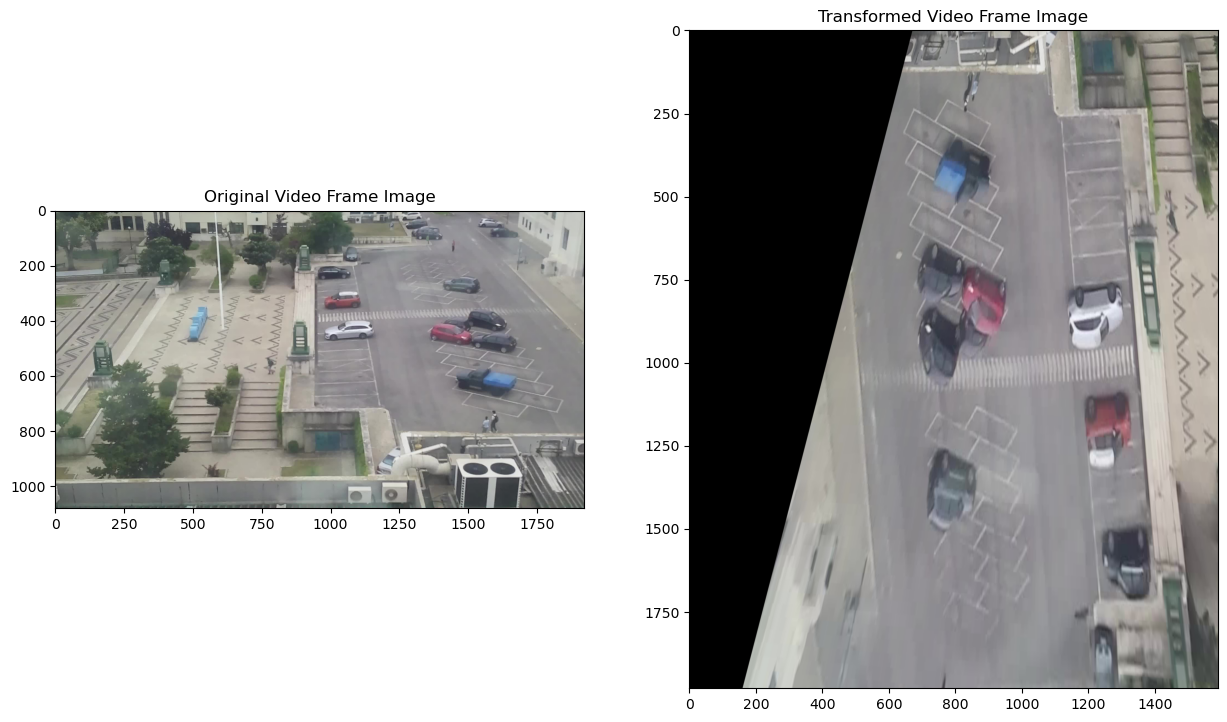

In [27]:
# Transform the first frame of the video using the homography matrix
transformed_image = cv2.warpPerspective(image_video_array, H, (image_maps_array.shape[1], image_maps_array.shape[0]))

# Plot the original and transformed images
fig, axes = plt.subplots(1, 2, figsize=(15, 10))

# Plot the original video frame image
axes[0].imshow(image_video_array)
axes[0].set_title('Original Video Frame Image')

# Plot the transformed image
axes[1].imshow(transformed_image)
axes[1].set_title('Transformed Video Frame Image')

# Show the plot
plt.show()

# 5. Visualizing transformed yolo

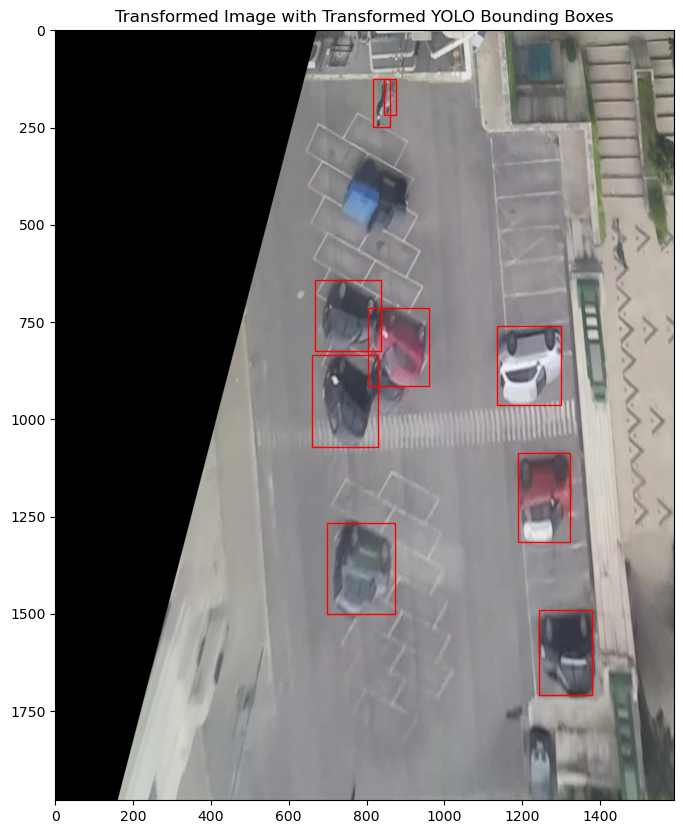

In [28]:
def transform_yolo_coordinates(yolo_mat_file, H):
    # Load the YOLO mat file
    yolo_data = sp.io.loadmat(yolo_mat_file)
    
    # Extract bounding box coordinates
    bounding_boxes = yolo_data['xyxy']
    
    # Transform the bounding box coordinates using the homography matrix
    transformed_bounding_boxes = []
    for bbox in bounding_boxes:
        x_min, y_min, x_max, y_max = bbox
        points = np.array([[x_min, y_min], [x_max, y_max]], dtype='float32')
        points = np.array([points])
        transformed_points = cv2.perspectiveTransform(points, H)[0]
        transformed_bounding_boxes.append([
            transformed_points[0][0], transformed_points[0][1],
            transformed_points[1][0], transformed_points[1][1]
        ])
    
    return np.array(transformed_bounding_boxes)

# Transform the YOLO coordinates
transformed_bounding_boxes = transform_yolo_coordinates(f'yolo/yolo_{video_frame}.mat', H)

# Plot the transformed image with transformed bounding boxes
fig, ax = plt.subplots(figsize=(15, 10))
ax.imshow(transformed_image)

# Plot each transformed bounding box
for bbox in transformed_bounding_boxes:
    x_min, y_min, x_max, y_max = bbox
    width, height = x_max - x_min, y_max - y_min
    rect = plt.Rectangle((x_min, y_min), width, height, edgecolor='red', facecolor='none')
    ax.add_patch(rect)

ax.set_title('Transformed Image with Transformed YOLO Bounding Boxes')
plt.show()

# 6. Transforming full video

In [29]:
# Create the output directory if it doesn't exist
warped_imgs_dir = Path('./warped_imgs')
warped_imgs_yolo_dir = Path('./warped_imgs_yolo')
warped_yolo_dir = Path('./warped_yolo_dir')

warped_imgs_dir.mkdir(parents=True, exist_ok=True)
warped_imgs_yolo_dir.mkdir(parents=True, exist_ok=True)
warped_yolo_dir.mkdir(parents=True, exist_ok=True)

# Initialize a dictionary to store transformed YOLO coordinates
transformed_yolo_dict = {}

# Get the list of image files and YOLO files
image_files = sorted([f for f in Path('./images').iterdir() if f.suffix == '.jpg'])
yolo_files = sorted([f for f in Path('./yolo').iterdir() if f.suffix == '.mat'])

In [31]:
image_files, yolo_files = image_files[:10], yolo_files[:10]

In [32]:
def load_img(img_path):
    return np.array(Image.open(img_path))

def transform_img(img, H):
    return cv2.warpPerspective(img, H, (img.shape[1], img.shape[0]))

def save_img(img, img_path):
    Image.fromarray(img).save(img_path)

def load_yolo(yolo_path):
    return sp.io.loadmat(yolo_path)['xyxy']

In [33]:
# Iterate through each image and YOLO file
for image_file, yolo_file in zip(image_files, yolo_files):
    # Load the image
    image_array = load_img(image_file)
    
    # Transform the image using the homography matrix
    transformed_image = transform_img(image_array, H)
    
    # Save the transformed image
    transformed_image_path = warped_imgs_dir / image_file.name
    # save_img(transformed_image, transformed_image_path)
    
    # Load the YOLO mat file
    bounding_boxes = load_yolo(yolo_file)
    
    # Transform the bounding box coordinates using the homography matrix
    transformed_bounding_boxes = []
    for bbox in bounding_boxes:
        x_min, y_min, x_max, y_max = bbox
        points = np.array([[x_min, y_min], [x_max, y_max]], dtype='float32')
        points = np.array([points])
        transformed_points = cv2.perspectiveTransform(points, H)[0]
        transformed_bounding_boxes.append([
            transformed_points[0][0], transformed_points[0][1],
            transformed_points[1][0], transformed_points[1][1]
        ])
    
    transformed_bounding_boxes = np.array(transformed_bounding_boxes)
    
    # Save the transformed YOLO coordinates in the dictionary
    transformed_yolo_dict[image_file] = transformed_bounding_boxes.tolist()
    
    # Plot the transformed image with transformed bounding boxes
    fig, ax = plt.subplots(figsize=(15, 10))
    ax.imshow(transformed_image)
    
    # Plot each transformed bounding box
    for bbox in transformed_bounding_boxes:
        x_min, y_min, x_max, y_max = bbox
        width, height = x_max - x_min, y_max - y_min
        rect = plt.Rectangle((x_min, y_min), width, height, edgecolor='red', facecolor='none')
        ax.add_patch(rect)
    
    ax.set_title(f'Transformed Image with Transformed YOLO Bounding Boxes: {image_file}')
    # Save the plot
    plot_path = warped_imgs_yolo_dir / image_file.name

    fig.savefig(plot_path)
    plt.close(fig)
